# Principal Component Analysis (PCA) implementation
This Jupyter Notebook contains implementation of two approaches for applying PCA and computing explained variance.
* Computing PCA via **covariance matrix** - this is useful when number of features is lower than number of records.
* Computing PCA via **Singular Value Decomposition (SVD)** - this approach is used in practice the most (Scikit-Learn library utilizes SVD for PCA).

We will work with Iris data set. To verify correctness of the code, we will use Scikit-Learn implemetation of PCA and compare the outputs of custom implementation.

First, we will start with importing packages and loading the data.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets

import warnings
warnings.filterwarnings('ignore')


def plot_iris(X_transformed, y, y_names, *, title):
    scatter = plt.scatter(*X_transformed.T, c=y)
    scatter_objects, _ = scatter.legend_elements()
    plt.legend(scatter_objects, y_names, loc='lower left', title='Classes')
    plt.title(title)
    plt.show()

In [3]:
# %% load data
dataset = datasets.load_iris()

X = dataset.data
y = dataset.target
y_names = dataset.target_names

## PCA through Covariance matrix

Computing PCA through Covariance matrix can be considered as the most simple and straightforward approach.

Given the input matrix X of dimensions $[n x m]$, the approach coveres following steps:
1. Center the data - that is subsracting off the mean for each dimension so that the data would have zero mean allong each dimension.

    This step can be considered similar to Standardization that is definded such as
    $$x_{standardized} = \frac{x - \bar{x}}{\sigma},$$

    where $\bar{x}$ and $\sigma$ denote mean and standard deviation, respectively, and $x$ and $x_{standardized}$ denote original variable and scaled variable, respectively. But due to the nature of PCA we cannot simply standartize the data because we will lose information about variance. Thus, centering the data si done by
    $$x_{centered} = x - \bar{x}.$$


2. Compute the covariance matrix - this is done by applying formula $C_X = \frac{1}{n}X^TX$, where $n$ is number of records (samples). For details of deriving this formula refer to **A Tutorial on Principal Component Analysis** [1]. Note, that in practive covariance is calcualted as $C_X = \frac{1}{n-1}X^TX$, where the slight change arrises from estimation theory.
3. Find eigen vectors - for this we will use method from linear algebra package called NumPy.
4. Compute the output, i.e. matrix of projected data - this is done by applying dot product for the input matrix and eigen vectors.


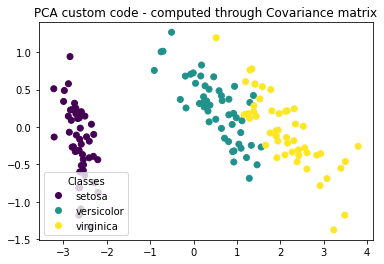

In [4]:
def pca_through_covariance_matrix(X, n_components=2):
    X = X.copy()
    n_samples, n_features = X.shape

    # center data - i.e. subtract off the mean for each dimension
    X -= np.mean(X, axis=0)
    assert np.allclose(X.mean(axis=0), np.zeros(X.shape[1]))

    # compute covariance matrix
    C = (X.T @ X) / (n_samples - 1)

    # find eigenvalues and eigenvectors (in this order)
    w, v = np.linalg.eig(C)

    # project the original data set
    X_transformed = X @ v

    # get variance explained
    C_transformed = (X_transformed.T @ X_transformed) / (n_samples - 1)
    explained_variance = C_transformed.diagonal()
    explained_variance_ratio = explained_variance / explained_variance.sum()

    # select only first two principal components
    X_transformed = X_transformed[:, :n_components]

    # note: In this implementation, we using full array of explaind variance.
    #       But implementation of Scikit-Learn is croping the array
    #       and storing only explained variance of n_components.

    return X_transformed, explained_variance, explained_variance_ratio


# %% custom pca (covariance matrix)
X_transformed_cov, explained_variance_cov, explained_variance_ratio_cov = pca_through_covariance_matrix(X)
plot_iris(X_transformed_cov, y, y_names, title='PCA custom code - computed through Covariance matrix')

## PCA through Singular Value Decomposition (SVD)

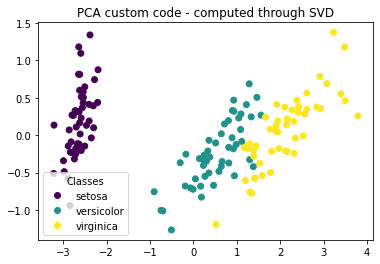

In [5]:
from sklearn.utils.extmath import svd_flip


def pca_through_svd(X, n_components=2):
    """
    Pieces of code were taken from scikit-learn library.
    See documentation page https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
    """
    X = X.copy()
    n_samples, n_features = X.shape

    # center data - i.e. subtract off the mean for each dimension
    X -= np.mean(X, axis=0)
    assert np.allclose(X.mean(axis=0), np.zeros(X.shape[1]))

    # compute singular value decomposition (SVD)
    U, S, V = np.linalg.svd(X, full_matrices=False)
    U, V = svd_flip(U, V)  # flip eigenvectors' sign to enforce deterministic output

    # create output variables (these are present in scikit-learn PCA object after it is fitted)
    components = V[:n_components]
    singular_values = S[:n_components]
    # X_transformed = X * V = U * S * V^T * V = U * S
    X_transformed = U[:, :n_components] * S[:n_components]

    # get variance explained
    explained_variance = (S ** 2) / (n_samples - 1)
    explained_variance_ratio = explained_variance / explained_variance.sum()

    # note: In this implementation, we using full array of explaind variance.
    #       But implementation of Scikit-Learn is croping the array
    #       and storing only explained variance of n_components.

    return X_transformed, explained_variance, explained_variance_ratio


# %% custom pca (with SVD) - utilized code from scikit-learn
X_transformed_svd, explained_variance_svd, explained_variance_ratio_svd = pca_through_svd(X)
plot_iris(X_transformed_svd, y, y_names, title='PCA custom code - computed through SVD')

## Scikit-Learn implementation of PCA

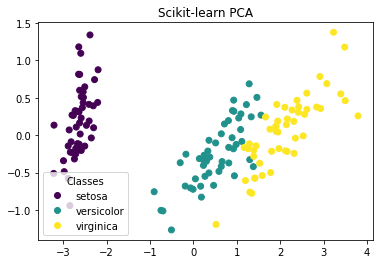

In [12]:
from sklearn.decomposition import PCA

def pca_scikit_learn(X, n_components=2):
    pca = PCA(n_components=n_components)
    X_transformed = pca.fit_transform(X)
    return X_transformed, pca.explained_variance_, pca.explained_variance_ratio_


# %% pca from scikit-learn - this implementation utilizes SVD
X_transformed_sklearn, explained_variance_sklearn, explained_variance_ratio_sklearn = pca_scikit_learn(X)
plot_iris(X_transformed_sklearn, y, y_names, title='Scikit-learn PCA')

## Comparison of variables

In [13]:
# %% compare variables
# compare output data
print('Output of custom SVD implementation is same as output of Scikit-Learn implementation:',
      (X_transformed_svd == X_transformed_sklearn).all())

print('Output of custom Covariance Matrix implementation is same as output of custom SVD implementation:',
      np.allclose(X_transformed_cov, X_transformed_svd))

print('Output of custom Covariance Matrix implementation is rotated on y-axis'
      ' compared to output of custom SVD implementation:',
      np.allclose(X_transformed_cov * [1, -1], X_transformed_svd))

# compare explained variance
print('Explained variance of custom Covariance Matrix implementation'
      ' is same as explained variance of custom SVD implementation:',
      np.allclose(explained_variance_cov, explained_variance_svd))

print('Explained variance of custom Covariance Matrix implementation'
      ' is same as explained variance of Scikit-Learn implementation:',
      np.allclose(explained_variance_cov[:2], explained_variance_sklearn))

Output of custom SVD implementation is same as output of Scikit-Learn implementation: True
Output of custom Covariance Matrix implementation is same as output of custom SVD implementation: False
Output of custom Covariance Matrix implementation is rotated on y-axis compared to output of custom SVD implementation: True
Explained variance of custom Covariance Matrix implementation is same as explained variance of custom SVD implementation: True
Explained variance of custom Covariance Matrix implementation is same as explained variance of Scikit-Learn implementation: True


## References

1.  J. Shlens: [A Tutorial on Principal Component Analysis](https://arxiv.org/abs/1404.1100v1). Google research, 2014.
2. [Scikit-Learn - PCA documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)